In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.io import loadmat
import mni_utils as uti

from pybispectra import compute_fft, get_example_data_paths, TDE

Paths and names:

In [3]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")

Get data and info:

In [14]:
data = loadmat(data_path.joinpath("MatlabFile.mat"))
data_W = data["Data_W"].T
data_N2 = data["Data_N2"].T
data_N3 = data["Data_N3"].T
data_R = data["Data_R"].T

# Export info as a dataframe
ch_names = data["ChannelName"].squeeze()
ch_types = data["ChannelType"].squeeze()
ch_regs = data["ChannelRegion"].squeeze()
pat_ids = data["Patient"].squeeze()
gender = data["Gender"].squeeze()
age = data["AgeAtTimeOfStudy"].squeeze()
ch_pos = data["ChannelPosition"].squeeze()
regions_map = {i + 1: r[0][0] for i, r in enumerate(data["RegionName"])}
sfreq = float(data["SamplingFrequency"][0][0])
df_info = pd.DataFrame(
    {
        "pat": pat_ids,
        "chan": [ch[0] for ch in ch_names],
        "type": [t[0] for t in ch_types],
        "region": ch_regs,
        "mni_x": ch_pos[:, 0],
        "mni_y": ch_pos[:, 1],
        "mni_z": ch_pos[:, 2],
    }
)

Example:

In [8]:
data_example = data_W[np.where(df_info["chan"].isin(["GD034Lr_3", "GD034Lu_2"]))]
raw = uti.create_RawMNE(data_example, ["GD034Lr_3", "GD034Lu_2"], sfreq)
epo = uti.create_epo(raw)
data_example = epo.get_data()
n_times = data_example.shape[2]

print(data_example.shape)

(118, 2, 200)


In [13]:
# compute Fourier coeffs.
fft_coeffs, freqs = compute_fft(
    data=data_example,
    sampling_freq=sfreq,
    n_points=2 * n_times + 1,  # recommended for time delay estimation
    window="hamming",
    verbose=False,
)

print(
    f"FFT coeffs.: [{fft_coeffs.shape[0]} epochs x {fft_coeffs.shape[1]} "
    f"channels x {fft_coeffs.shape[2]} frequencies]\nFreq. range: "
    f"{freqs[0]:.0f} - {freqs[1]:.0f} Hz"
)

FFT coeffs.: [118 epochs x 2 channels x 201 frequencies]
Freq. range: 0 - 0 Hz


In [27]:
np.c_[np.array([1,2,3]), np.array([4,5,6])]

array([[1, 4],
       [2, 5],
       [3, 6]])

In [29]:
tde = TDE(
    data=fft_coeffs, freqs=freqs, sampling_freq=sfreq, verbose=False
)  # initialise object
tde.compute(indices=((0,), (1,)), fmin=(0,), fmax=(sfreq/ 2,), method=1, antisym=True)  # compute TDE
tde_times = tde.results.times

tde_results = tde.results.get_results()  # return results as array

print(
    f"TDE results: [{tde_results.shape[0]} connections x "
    f"{tde_results.shape[1]} frequency bands x {tde_results.shape[2]} times]"
)

TDE results: [1 connections x 1 frequency bands x 401 times]


In [30]:
tde_results.shape

(1, 1, 401)

In [34]:
tde_times[np.argmax(tde_results)]

-115.0

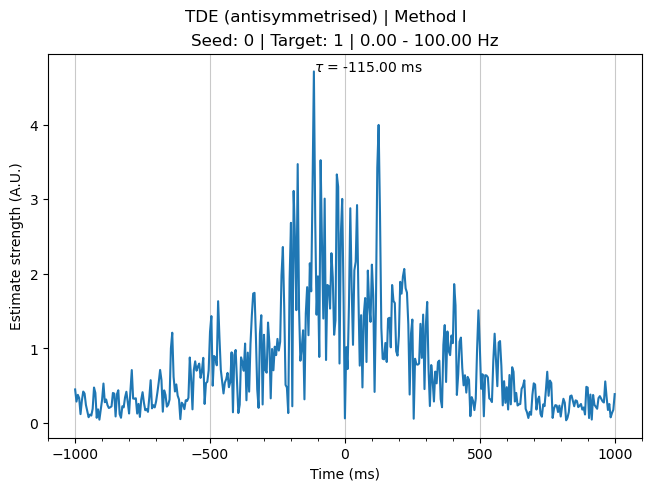

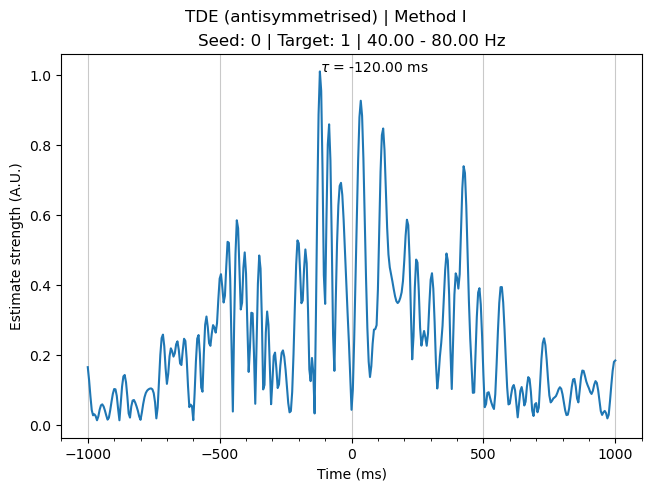

In [22]:
# print(
#     "The estimated time delay between signals 0 and 1 is "
#     f"{tde_times[tde_results[0].argmax()]:.0f} ms.\n"
#     "The estimated time delay between signals 1 and 0 is "
#     f"{tde_times[tde_results[1].argmax()]:.0f} ms."
# )

# for con_i in range(tde_results.shape[0]):
#     assert tde_times[tde_results[con_i].argmax()] == tde.results.tau[con_i]

fig, axes = tde.results.plot()

In [ ]:
# TODO: embed it in compute_SC function

In [35]:
df_sc = pd.read_csv("F:\iEEG_neural_dynamics\MNIOpen\Results_SC_bispectrum\SC_W.csv", index_col=0)
df_sc.head()

,ch_1,ch_2,lobe_1,lobe_2,region_1,region_2,mmp_1,mmp_2,dist,corr_0,corr_max,lag_max,pat
0,GD001Lc_11,GD001Lc_12,Temporal,Temporal,Middle temporal gyrus,Middle temporal gyrus,STSvp,STSvp,4.472136,[0.05881521],7.347585,-10.0,1
1,GD001Lc_11,GD001Lc_13,Temporal,Temporal,Middle temporal gyrus,Middle temporal gyrus,STSvp,TE1p,7.000000,[0.01030153],6.463584,-10.0,1
2,GD001Lc_11,GD001Lc_14,Temporal,Temporal,Middle temporal gyrus,Middle temporal gyrus,STSvp,TE1p,12.041595,[0.0643914],7.745968,-10.0,1
3,GD001Lc_11,GD001Lo_1,Temporal,Frontal,Middle temporal gyrus,Medial frontal cortex,STSvp,10r,97.005155,[0.01483041],3.820035,-110.0,1
4,GD001Lc_11,GD001Lo_2,Temporal,Frontal,Middle temporal gyrus,Medial frontal cortex,STSvp,10r,95.336247,[0.02541206],3.872702,-110.0,1


In [39]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [44]:
popt, _ = curve_fit(lambda x, k, a, b: a * np.exp(-x/k) + b, df_sc["dist"], df_sc["corr_max"])
print(popt)

[6.5577291  7.82901237 3.59508652]


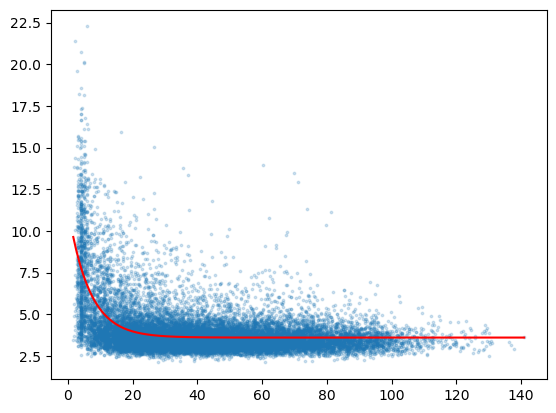

In [43]:
plt.scatter(df_sc["dist"], df_sc["corr_max"], s=3, alpha=0.2)
plt.plot(df_sc["dist"].sort_values(), popt[1] * np.exp(-df_sc["dist"].sort_values() / popt[0]) + popt[2], c="r")
plt.show()

### D) Correlation with Timescales

In [48]:
from scipy.stats import false_discovery_control

In [45]:
map_coords = pd.read_csv(data_path.joinpath("mnia_centroids_coords.csv"), index_col=0)

In [61]:

# Dataframe with the fit parameters on each MNI region
df_sc_params_mni_stages = {
    stage: pd.read_csv(data_path.joinpath("Results_SC_bispectrum", f"SC_{stage}_fit_mni_regs.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

Timescales:

In [62]:
# Dataframe with timescales for all electrodes
df_tau = pd.read_csv(data_path.joinpath("Results_acf_fit_exp", "all_tau.csv"), index_col=0)

LFP:

In [65]:
# Gather all p-values to correct
df_rhos = pd.DataFrame(index=["k", "a", "b"], columns=["W", "N3", "R"], dtype=float)
df_pvals = pd.DataFrame(index=["k", "a", "b"], columns=["W", "N3", "R"], dtype=float)
rhos_boot = {stage: {} for stage in ["W", "N3", "R"]}

# Plot one figure per parameter
for i, stage in enumerate(["W", "N3", "R"]):

    # Get average tau per MNI region
    df_tau_stage_mni = uti.get_avg_tau_mni(
        df_tau[df_tau["stage"] == stage].copy(), method="LME"
    )

    for param in ["k", "a", "b"]:

        print(f"Stage: {stage}, Param: {param}")

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Get correlation values
        rho, p_corr = uti.get_pcorr_mnia(
            df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="pearson"
        )

        df_rhos.loc[param, stage] = rho
        df_pvals.loc[param, stage] = p_corr
        rhos_boot[stage][param] = uti.get_rho_boot(
            df_tau_stage_mni, df_spa, corr_type="pearson", nboot=1
        )


# Correct with FDR correction
pvals_corr = df_pvals.to_numpy() # false_discovery_control(df_pvals.to_numpy().ravel())
df_pvals_corr = pd.DataFrame(
    pvals_corr.reshape(df_pvals.shape), index=df_pvals.index, columns=df_pvals.columns
)

Stage: W, Param: k
Generating 1000 permutations...


c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\scipy\stats\_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stage: W, Param: a
Generating 1000 permutations...


c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\scipy\stats\_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stage: W, Param: b
Generating 1000 permutations...


c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\scipy\stats\_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stage: N3, Param: k
Generating 1000 permutations...


c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\scipy\stats\_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stage: N3, Param: a
Generating 1000 permutations...


c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\scipy\stats\_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stage: N3, Param: b
Generating 1000 permutations...


c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\scipy\stats\_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stage: R, Param: k
Generating 1000 permutations...


c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\scipy\stats\_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stage: R, Param: a
Generating 1000 permutations...


c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\scipy\stats\_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stage: R, Param: b
Generating 1000 permutations...


c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\scipy\stats\_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stage: W, Param: k
Stage: N3, Param: k
Stage: R, Param: k


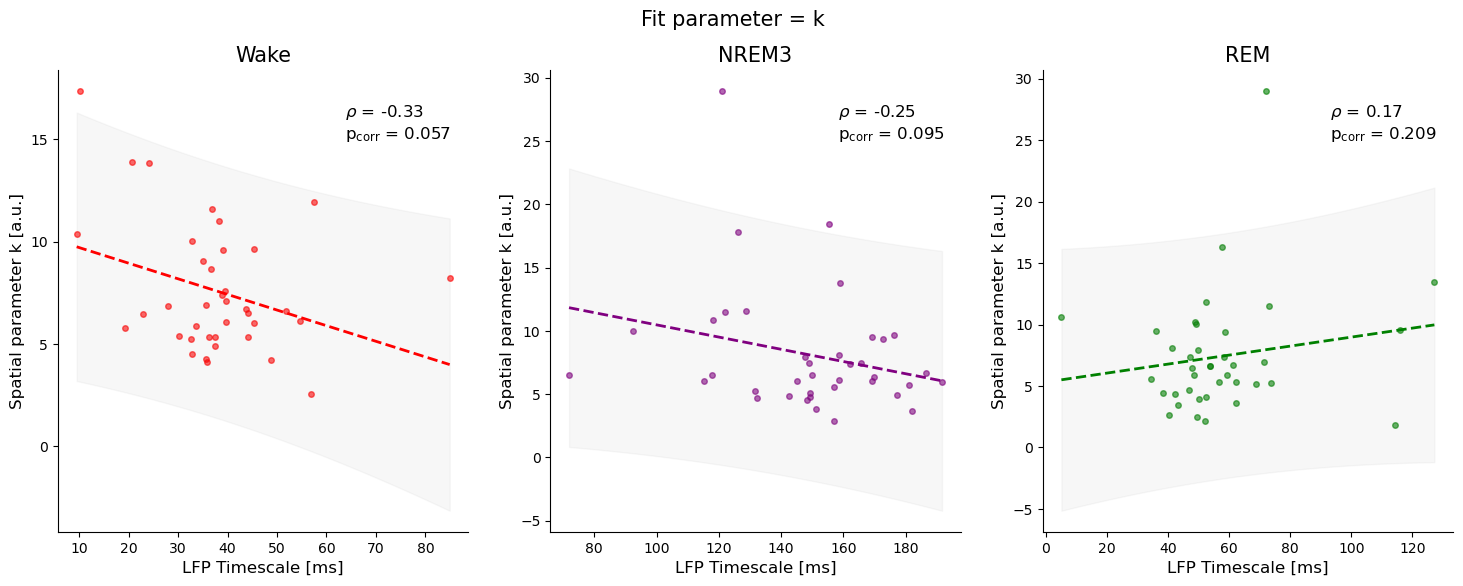

Stage: W, Param: a
Stage: N3, Param: a
Stage: R, Param: a


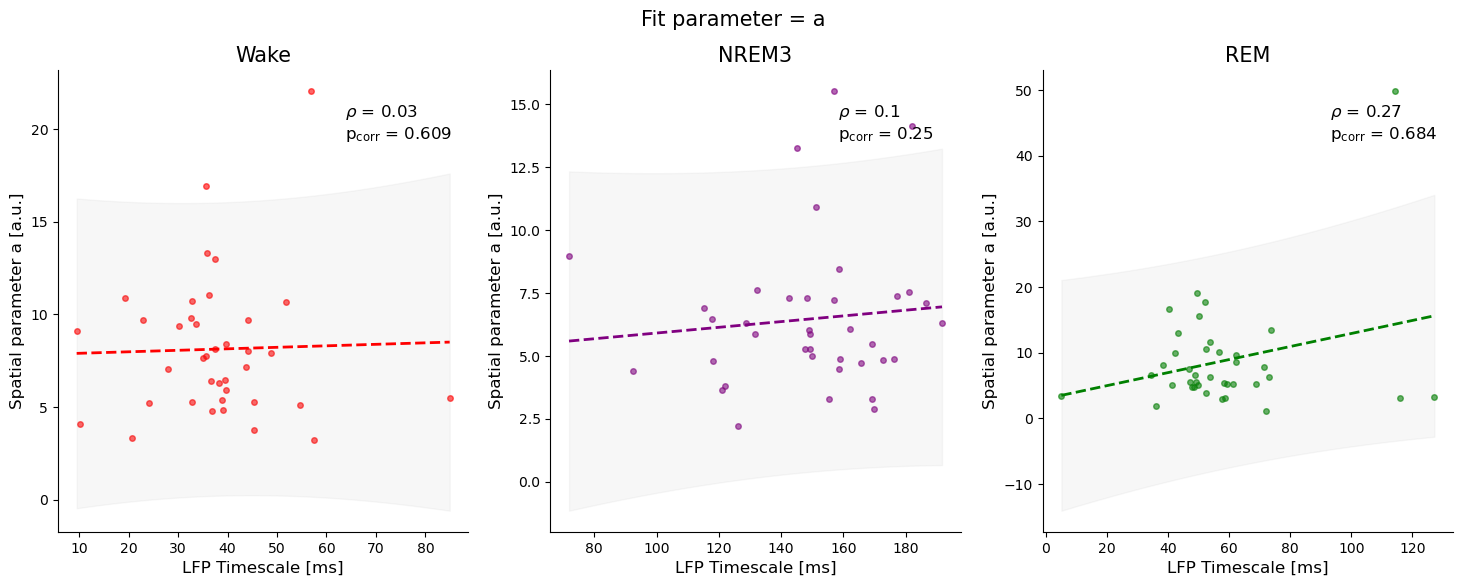

Stage: W, Param: b
Stage: N3, Param: b
Stage: R, Param: b


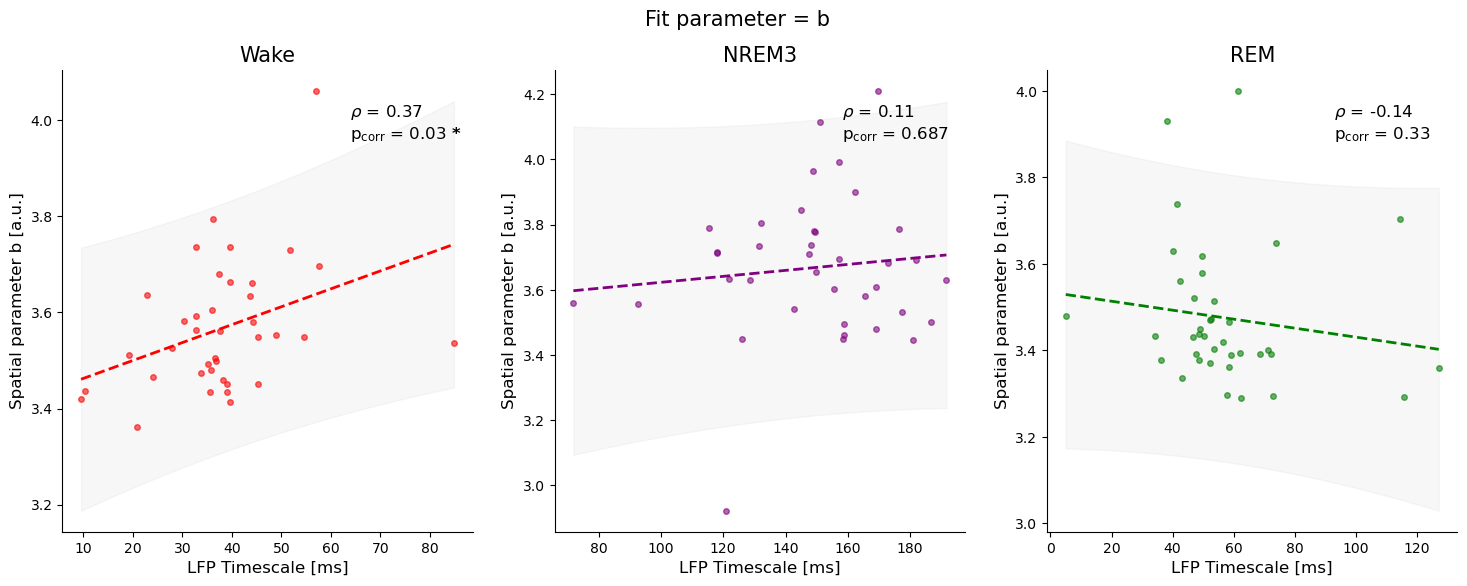

In [66]:
from mni_plots import plot_corr

colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot one figure per parameter
for param in ["k", "a", "b"]:

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18, 6])
    fig.suptitle(f"Fit parameter = {param}", fontsize=15)

    # One subplot per stage
    for i, stage in enumerate(["W", "N3", "R"]):
        print(f"Stage: {stage}, Param: {param}")

        # Get average tau per MNI region
        df_tau_stage_mni = uti.get_avg_tau_mni(
            df_tau[df_tau["stage"] == stage].copy(), method="LME"
        )

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Plot
        axs[i] = plot_corr(
            axs[i],
            df_tau_stage_mni.to_numpy().squeeze(),
            df_spa.to_numpy().squeeze(),
            df_rhos.loc[param, stage],
            df_pvals_corr.loc[param, stage],
            color=colors_stage[stage],
            title=title_dict[stage],
            xlabel="LFP Timescale [ms]",
            ylabel=f"Spatial parameter {param} [a.u.]",
        )

    plt.show()

AUC:

Stage: W
Generating 1000 permutations...
Stage: N3
Generating 1000 permutations...
Stage: R
Generating 1000 permutations...


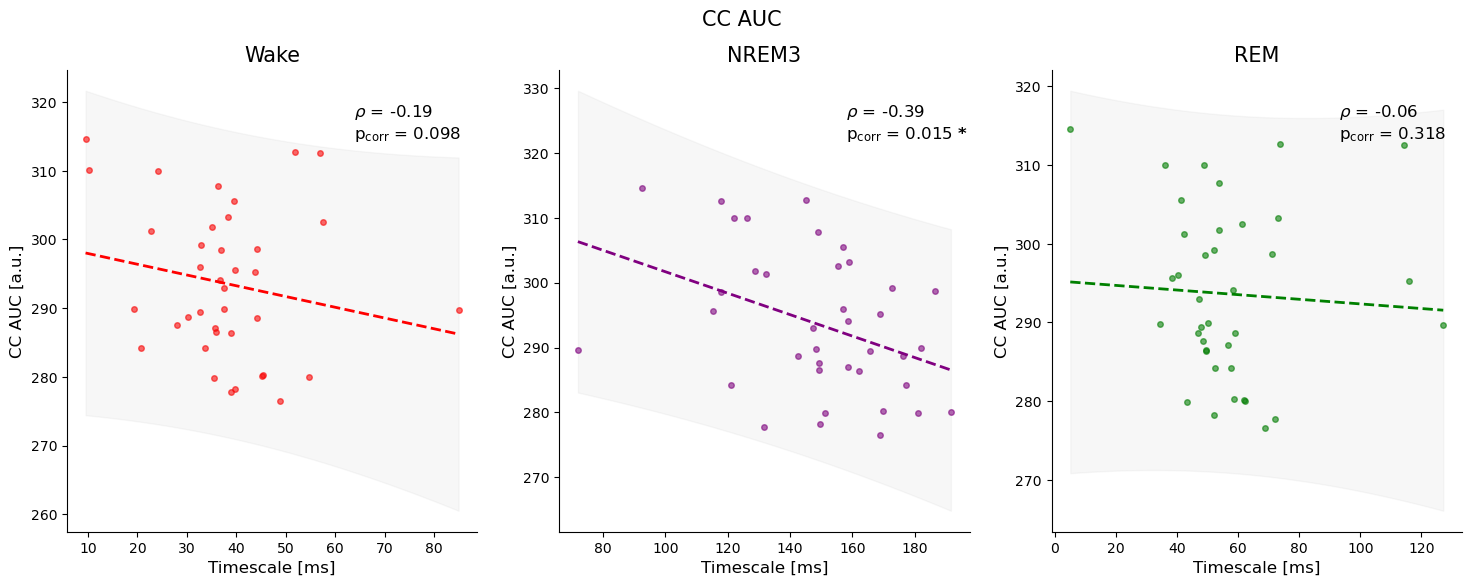

In [67]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Define figure
fig, axs = plt.subplots(1, 3, figsize=[18, 6])
fig.suptitle(f"CC AUC", fontsize=15)

# One subplot per stage
for i, stage in enumerate(["W", "N3", "R"]):
    print(f"Stage: {stage}")

    # Get average tau per MNI region
    df_tau_stage_mni = uti.get_avg_tau_mni(df_tau[df_tau["stage"] == stage].copy())

    # Get AUC
    # auc_regions = {}
    # for reg in df_tau_stage_mni.index:
    #     df_sc_reg = df_sc_stages[stage][
    #             (df_sc_stages[stage]["region_1"] == reg)
    #             | (df_sc_stages[stage]["region_2"] == reg)
    #         ]
    #     df_sc_bin_reg = uti.compute_sc_bin(df_sc_reg, bins=np.arange(0, 101, 10))
    #     auc_regions[reg] = df_sc_bin_reg["corr_max"][(df_sc_bin_reg["bin"] >= 10) & (df_sc_bin_reg["bin"] < 80)].mean()
    def get_AUC(x):
        return x["a"] * x["k"] * (np.exp(-5/x["k"]) - np.exp(-80/x["k"])) + x["b"] * (80 - 5)

    df_spa = df_sc_params_mni_stages["W"].astype(float).apply(get_AUC, axis=1)
    # df_spa = pd.Series(auc_regions)
    df_spa = df_spa.loc[df_tau_stage_mni.index]

    # Get correlation values
    rho, p_corr = uti.get_pcorr_mnia(
        df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="pearson"
    )

    # Plot
    axs[i] = plot_corr(
        axs[i],
        df_tau_stage_mni.to_numpy().squeeze(),
        df_spa.to_numpy().squeeze(),
        rho,
        p_corr,
        color=colors_stage[stage],
        title=title_dict[stage],
        xlabel="Timescale [ms]",
        ylabel=f"CC AUC [a.u.]",
    )

plt.show()